In [1]:
from PIL import Image
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


In [2]:
def quantize_image(image_np, n_colors):
    """
    Quantize the input image into n_colors using KMeans clustering
    """

    # Reshaping the image for KMeans
    pixels = image_np.reshape(-1, 3)
    
    # KMeans clustering
    kmeans = KMeans(n_clusters=n_colors)
    kmeans.fit(pixels)
    new_pixels = kmeans.cluster_centers_[kmeans.labels_]
    
    # Reshape to the original image shape
    quantized_image = new_pixels.reshape(image_np.shape).astype('uint8')
    return quantized_image

In [3]:
# Load the image
image_path = '/home/asblab/aaron/s3/process_hdmaps/hdmap4.jpg'
image = Image.open(image_path)

# Convert the image into numpy array, image_np.shape = (height, width, 3)
image_np = np.array(image)

# Let's assume the user specified 3 colors
n_colors = 3

In [4]:
print("shape of image_np: ", image_np.shape)
print("number of unique colors: ", len(np.unique(image_np.reshape(-1, 3), axis=0)))


shape of image_np:  (1668, 2388, 3)
number of unique colors:  5589


In [5]:
# Quantize the image
quantized_image_np = quantize_image(image_np, n_colors)

In [6]:
print("shape of image_np: ", quantized_image_np.shape)
print("number of unique colors: ", len(np.unique(quantized_image_np.reshape(-1, 3), axis=0)))

shape of image_np:  (1668, 2388, 3)
number of unique colors:  3


In [7]:
# Also calculate and print the number of unique colors after quantization
unique_colors_after, counts_after = np.unique(quantized_image_np.reshape(-1, quantized_image_np.shape[2]), axis=0, return_counts=True)

# Dictionary to hold color codes (in hex) and counts
unique_colors_counts_after = {f"#{color[0]:02x}{color[1]:02x}{color[2]:02x}": count for color, count in zip(unique_colors_after, counts_after)}

print("Unique colors and their counts after quantization: ", unique_colors_counts_after)

Unique colors and their counts after quantization:  {'#000000': 2984135, '#0d0ee3': 73094, '#fefefe': 925955}


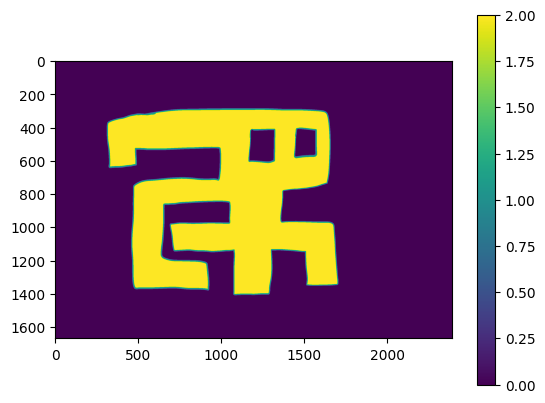

In [8]:
# Create a 2D array to hold the index of the color for each pixel
indexed_color_image = np.zeros((quantized_image_np.shape[0], quantized_image_np.shape[1]), dtype=int)

# Iterate over unique colors to create a mapping from color to index
color_to_index = {tuple(color): idx for idx, color in enumerate(unique_colors_after)}

# Populate the indexed_color_image with the index of each pixel's color
for i in range(quantized_image_np.shape[0]):
    for j in range(quantized_image_np.shape[1]):
        indexed_color_image[i, j] = color_to_index[tuple(quantized_image_np[i, j])]
# plot the indexed color image
plt.imshow(indexed_color_image)

# include a color bar for the legend
plt.colorbar()
plt.show()


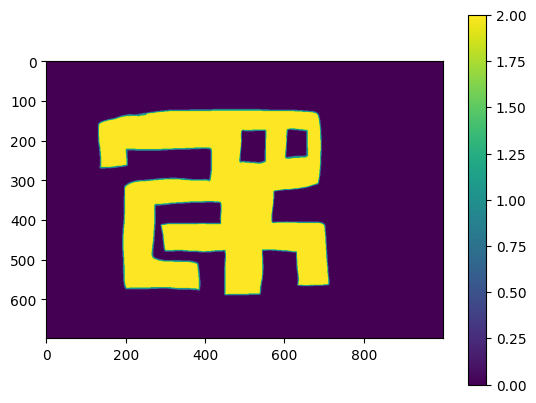

In [9]:
def create_indexed_color_image_at_resolution(quantized_image_np, target_width):
    """
    Create an indexed color image at a user specified resolution, maintaining the aspect ratio.
    
    Parameters:
    - quantized_image_np: Numpy array of the quantized image.
    - target_width: The target width for the output image.
    
    Returns:
    - indexed_color_image_resized: The indexed color image at the specified resolution.
    """
    from skimage.transform import resize
    
    # Calculate the new height to maintain the aspect ratio
    aspect_ratio = quantized_image_np.shape[0] / quantized_image_np.shape[1]
    target_height = int(target_width * aspect_ratio)
    
    # Resize the quantized image to the target resolution
    quantized_image_resized = resize(quantized_image_np, (target_height, target_width), 
                                      order=0, preserve_range=True, anti_aliasing=False).astype(int)
    
    # Calculate unique colors in the resized image
    unique_colors_resized, counts_resized = np.unique(quantized_image_resized.reshape(-1, 3), axis=0, return_counts=True)
    
    # Create a 2D array to hold the index of the color for each pixel in the resized image
    indexed_color_image_resized = np.zeros((target_height, target_width), dtype=int)
    
    # Iterate over unique colors to create a mapping from color to index for the resized image
    color_to_index_resized = {tuple(color): idx for idx, color in enumerate(unique_colors_resized)}
    
    # Populate the indexed_color_image_resized with the index of each pixel's color
    for i in range(target_height):
        for j in range(target_width):
            indexed_color_image_resized[i, j] = color_to_index_resized[tuple(quantized_image_resized[i, j])]
    
    return indexed_color_image_resized

# Example usage
target_width = 1000  # User specified width
indexed_color_image_resized = create_indexed_color_image_at_resolution(quantized_image_np, target_width)

# Plot the indexed color image at the new resolution
plt.imshow(indexed_color_image_resized)
plt.colorbar()

# Save the resized image based on the target_width in the file name
plt.savefig(f'/home/asblab/aaron/s3/process_hdmaps/hdmap2_indexed_color_image_resized_{target_width}.png')
plt.show()

In [10]:
# print unique values in the indexed_color_image
print("unique values in the indexed_color_image: ", np.unique(indexed_color_image))
print("count of values with 0: ", len(indexed_color_image[indexed_color_image == 0]))
print("count of values with 1: ", len(indexed_color_image[indexed_color_image == 1]))
print("count of values with 2: ", len(indexed_color_image[indexed_color_image == 2]))

unique values in the indexed_color_image:  [0 1 2]
count of values with 0:  2984135
count of values with 1:  73094
count of values with 2:  925955


In [11]:
# Convert back to image to check the output
quantized_image = Image.fromarray(quantized_image_np)

# Save the quantized image
quantized_image.save('/home/asblab/aaron/s3/process_hdmaps/hdmap2_quantized.jpg')

In [12]:
print("shape of image_np: ", indexed_color_image_resized.shape)
print("number of unique colors: ", len(np.unique(indexed_color_image_resized)))
print("count of values with 0: ", len(indexed_color_image_resized[indexed_color_image_resized == 0]))
print("count of values with 1: ", len(indexed_color_image_resized[indexed_color_image_resized == 1]))
print("count of values with 2: ", len(indexed_color_image_resized[indexed_color_image_resized == 2]))

shape of image_np:  (698, 1000)
number of unique colors:  3
count of values with 0:  522849
count of values with 1:  12883
count of values with 2:  162268


In [13]:
indexed_color_image_resized

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

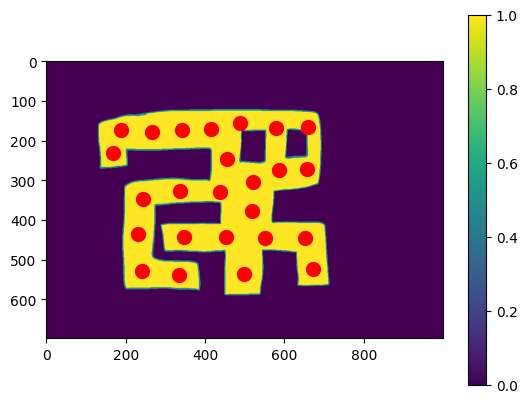

In [14]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

# Assuming indexed_color_image_resized is already defined
# User-defined number of clusters
n_clusters = 25  # Example: 5 clusters

# Step 1: Extract coordinates of cells with value 2
coords = np.column_stack(np.where(indexed_color_image_resized == 2))

# Step 2: Use KMeans to cluster these coordinates
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(coords)
centroids = kmeans.cluster_centers_

# Step 3: Round centroids to nearest integer to use as indices. centroids are 2D pixel values.
centroids = np.rint(centroids).astype(int)

# Plot the original image
plt.imshow(indexed_color_image_resized)

# Step 4: Plot centroids as larger blobs
for centroid in centroids:
    plt.scatter(centroid[1], centroid[0], s=100, c='red', marker='o')  # s is the size of the centroid blob

plt.colorbar()
plt.show()

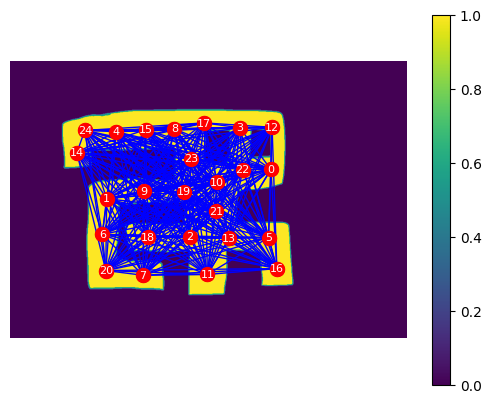

In [22]:
import networkx as nx

# Assuming the rest of your code is the same and centroids are defined

# Create a graph
G = nx.Graph()

# Add nodes with centroids positions
for i, centroid in enumerate(centroids):
    G.add_node(i, pos=(centroid[1], centroid[0]))

# For simplicity, connect each node to every other node (fully connected graph)
# For more complex connections, you might need a different approach
for i in G.nodes:
    for j in G.nodes:
        if i != j:
            G.add_edge(i, j)

# Plot the original image and centroids
plt.imshow(indexed_color_image_resized, cmap='viridis')
for centroid in centroids:
    plt.scatter(centroid[1], centroid[0], s=100, c='red', marker='o')

# Draw the networkx graph on top of the matplotlib plot
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=True, node_color='red', edge_color='blue', node_size=100, font_size=8, font_color='white')

plt.colorbar()
plt.show()

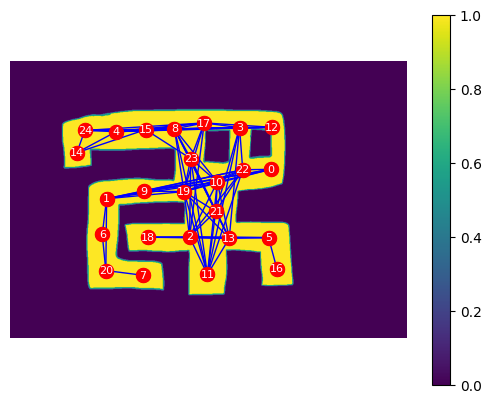

In [16]:
from skimage.draw import line
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Assuming G is your graph and pos contains positions of nodes as per your previous code

# User-defined threshold for deciding if an edge should be kept
threshold_percentage = 98

# Function to draw a line and return pixel values along the line
def get_line_pixel_values(img, start, end):
    # Use skimage's line function to get pixel coordinates
    rr, cc = line(start[0], start[1], end[0], end[1])  # Note: line expects (y, x) format for start and end
    # Sample the pixel values along the line
    pixel_values = img[rr, cc]
    return pixel_values

# Temporary graph to modify based on the threshold condition
G_temp = G.copy()

# Iterate through each edge in the graph
for edge in G.edges():
    node, neighbor = edge
    node_pos = pos[node]
    neighbor_pos = pos[neighbor]
    
    # Convert positions from (x, y) to (y, x) because image arrays are indexed as [row, column]
    node_pos_yx = (node_pos[1], node_pos[0])
    neighbor_pos_yx = (neighbor_pos[1], neighbor_pos[0])
    
    # Get pixel values along the line between node and neighbor
    line_pixel_values = get_line_pixel_values(indexed_color_image_resized, node_pos_yx, neighbor_pos_yx)
    
    # Calculate unique values and their counts
    unique_values, counts = np.unique(line_pixel_values, return_counts=True)
    
    # Check if the value 2 meets the threshold
    if 2 in unique_values:
        index_of_2 = np.where(unique_values == 2)[0][0]
        percentage_of_2 = (counts[index_of_2] / sum(counts)) * 100
        if percentage_of_2 < threshold_percentage:
            # Remove the edge if it doesn't meet the threshold
            G_temp.remove_edge(node, neighbor)
    else:
        # Remove the edge if 2 is not among the unique values
        G_temp.remove_edge(node, neighbor)


# Plot the original image and centroids
plt.imshow(indexed_color_image_resized, cmap='viridis')
for centroid in centroids:
    plt.scatter(centroid[1], centroid[0], s=100, c='red', marker='o')

# Draw the networkx graph on top of the matplotlib plot
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G_temp, pos, with_labels=True, node_color='red', edge_color='blue', node_size=100, font_size=8, font_color='white')

plt.colorbar()
plt.show()


Calculated max_distance based on average shortest distance: 129.93977112163705


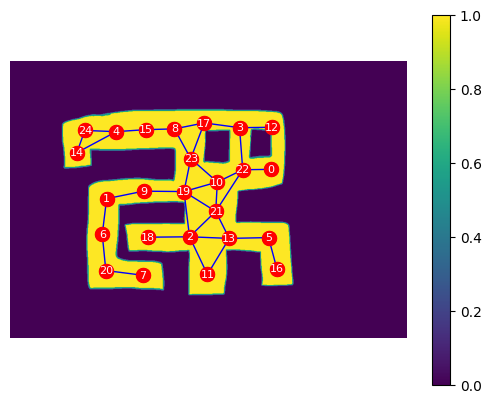

In [20]:
import numpy as np
import networkx as nx
from skimage.draw import line
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Function to calculate Euclidean distance between two points
def calculate_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

# List to store the shortest distance from each node to its nearest neighbor
shortest_distances = []

# Temporary graph to modify based on the conditions
G_temp = G.copy()

# Iterate through each node in the graph
for node in G_temp.nodes:
    node_pos = pos[node]
    distances = []
    # Calculate distance from this node to all other nodes
    for neighbor in G_temp.nodes:
        if node != neighbor:
            neighbor_pos = pos[neighbor]
            distance = calculate_distance(node_pos, neighbor_pos)
            distances.append(distance)
    # Find the shortest distance for this node
    if distances:
        shortest_distances.append(min(distances))

# Calculate the average of these shortest distances
if shortest_distances:
    average_shortest_distance = np.mean(shortest_distances)
    max_distance = average_shortest_distance * 1.6 # adjust weight based on tuning
else:
    max_distance = 100  # Default value in case there are no distances

print(f"Calculated max_distance based on average shortest distance: {max_distance}")

# User-defined threshold for deciding if an edge should be kept based on pixel values
threshold_percentage = 98

# Function to draw a line and return pixel values along the line
def get_line_pixel_values(img, start, end):
    # Use skimage's line function to get pixel coordinates
    rr, cc = line(start[0], start[1], end[0], end[1])  # Note: line expects (y, x) format for start and end
    # Sample the pixel values along the line
    pixel_values = img[rr, cc]
    return pixel_values

# Function to calculate Euclidean distance between two points
def calculate_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

# Temporary graph to modify based on the conditions
G_temp = G.copy()

# Iterate through each edge in the graph
for edge in G.edges():
    node, neighbor = edge
    node_pos = pos[node]
    neighbor_pos = pos[neighbor]
    
    # Convert positions from (x, y) to (y, x) because image arrays are indexed as [row, column]
    node_pos_yx = (node_pos[1], node_pos[0])
    neighbor_pos_yx = (neighbor_pos[1], neighbor_pos[0])
    
    # Calculate the distance between the node and its neighbor
    distance = calculate_distance(node_pos_yx, neighbor_pos_yx)
    
    # Check if the distance exceeds the maximum allowed distance
    if distance > max_distance:
        G_temp.remove_edge(node, neighbor)
        continue  # Skip the rest of the loop and proceed with the next edge
    
    # Get pixel values along the line between node and neighbor
    line_pixel_values = get_line_pixel_values(indexed_color_image_resized, node_pos_yx, neighbor_pos_yx)
    
    # Calculate unique values and their counts
    unique_values, counts = np.unique(line_pixel_values, return_counts=True)
    
    # Check if the value 2 meets the threshold
    if 2 in unique_values:
        index_of_2 = np.where(unique_values == 2)[0][0]
        percentage_of_2 = (counts[index_of_2] / sum(counts)) * 100
        if percentage_of_2 < threshold_percentage:
            # Remove the edge if it doesn't meet the threshold
            G_temp.remove_edge(node, neighbor)
    else:
        # Remove the edge if 2 is not among the unique values
        G_temp.remove_edge(node, neighbor)

# Plot the original image and centroids
plt.imshow(indexed_color_image_resized, cmap='viridis')
for centroid in centroids:
    plt.scatter(centroid[1], centroid[0], s=100, c='red', marker='o')

# Draw the networkx graph on top of the matplotlib plot
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G_temp, pos, with_labels=True, node_color='red', edge_color='blue', node_size=100, font_size=8, font_color='white')

plt.colorbar()
plt.show()


In [19]:
print("shape of image_np: ", indexed_color_image_resized.shape)
print("number of unique colors: ", len(np.unique(indexed_color_image_resized)))
print("count of values with 0: ", len(indexed_color_image_resized[indexed_color_image_resized == 0]))
print("count of values with 1: ", len(indexed_color_image_resized[indexed_color_image_resized == 1]))
print("count of values with 2: ", len(indexed_color_image_resized[indexed_color_image_resized == 2]))

shape of image_np:  (698, 1000)
number of unique colors:  3
count of values with 0:  522849
count of values with 1:  12883
count of values with 2:  162268
